# Project Name : Text Summarization
# Author : Saravanan R
# Submitted for : HCL Internship

In [1]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
tf.__version__

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


'2.8.0'

# Importing Dataset - cnn_dailymail

In [2]:
import datasets
train_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

Using the latest cached version of the module from /Users/tensorflow/.cache/huggingface/modules/datasets_modules/datasets/cnn_dailymail/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234 (last modified on Mon Apr 11 23:08:30 2022) since it couldn't be found locally at cnn_dailymail., or remotely on the Hugging Face Hub.
Reusing dataset cnn_dailymail (/Users/tensorflow/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)
Using the latest cached version of the module from /Users/tensorflow/.cache/huggingface/modules/datasets_modules/datasets/cnn_dailymail/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234 (last modified on Mon Apr 11 23:08:30 2022) since it couldn't be found locally at cnn_dailymail., or remotely on the Hugging Face Hub.
Reusing dataset cnn_dailymail (/Users/tensorflow/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c

In [3]:
train_data[0]

{'article': 'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but bec

# Data Visualization

## Creating DataFrames

In [88]:
df = pd.DataFrame()

df["text"] = train_data['article'][:10000]
df['summary'] = train_data['highlights'][:10000]

df.head()

,text,summary
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours ...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military..."
1,(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charge...,Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the G...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting prog..."
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him ...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also sus..."
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18...",Another arrest made in gang rape outside California school .\nInvestigators say up to 20 people took part or stood and watched the assault .\nFour suspects appeared in court Thursday; three wore b...


In [89]:
val = pd.DataFrame()

val["text"] = val_data['article'][:5000]
val['summary'] = val_data['highlights'][:5000]

val.head()
val.info

<bound method DataFrame.info of                                                                                                                                                                                                          text  \
0     (CNN)Singer-songwriter David Crosby hit a jogger with his car Sunday evening, a spokesman said. The accident happened in Santa Ynez, California, near where Crosby lives. Crosby was driving at appr...   
1     (CNN)Sigma Alpha Epsilon is under fire for a video showing party-bound fraternity members singing a racist chant. SAE's national chapter suspended the students, but University of Oklahoma Presiden...   
2     (CNN)I'm Candida Moss and I am professor of New Testament and Early Christianity at the University of Notre Dame. I was an adviser on the "True Cross" episode and served as one of the many on-came...   
3     (CNN)Ferguson is crumbling. The cowardly and reprehensible shooting Wednesday night of two police officers came in a tumultuou

In [90]:
test = pd.DataFrame()

test["text"] = test_data['article']
test['summary'] = test_data['highlights']

test.head()

,text,summary
0,"(CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV's ""The Dukes of Hazzard,"" died Monday after a brief illness. He was 88. Best died in hospice in Hickory, N...","James Best, who played the sheriff on ""The Dukes of Hazzard,"" died Monday at 88 .\n""Hazzard"" ran from 1979 to 1985 and was among the most popular shows on TV ."
1,"(CNN)The attorney for a suburban New York cardiologist charged in what authorities say was a failed scheme to have another physician hurt or killed is calling the allegations against his client ""c...","A lawyer for Dr. Anthony Moschetto says the charges against him are baseless .\nMoschetto, 54, was arrested for selling drugs and weapons, prosecutors say .\nAuthorities allege Moschetto hired acc..."
2,"(CNN)President Barack Obama took part in a roundtable discussion this week on climate change, refocusing on the issue from a public health vantage point. After the event at Washington's Howard Uni...","""No challenge poses more of a public threat than climate change,"" the President says .\nHe credits the Clean Air Act with making Americans ""a lot"" healthier ."
3,"Moscow (CNN)A Russian TV channel aired Hillary Clinton's first campaign video with a rating stamp that means it's for mature audiences, because of fears it might run afoul of the country's anti-ga...","Presidential hopeful's video, featuring gay couple, gets mature rating in Russia .\nRussian TV channel feared airing it would break the country's anti-gay propaganda law .\nClinton announced her s..."
4,"(CNN)Marco Rubio is all in. The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the prom...","Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations .\nHe says on health care, climate change and other issues, he breaks from..."


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     10000 non-null  object
 1   summary  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [92]:
df['text'][:10]

0    It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours ...
1    (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charge...
2    Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the G...
3    Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him ...
4    (CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jo

In [93]:
df['summary'][:10]

0    Syrian official: Obama climbed to the top of the tree, "doesn't know how to get down"\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military...
1                    Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .
2    The employee in agency's Kansas City office is among hundreds of "virtual" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting prog...
3    NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: "autism, severe anxiety, post-traumatic stress disorder and depression"\nBurkhart is also sus...
4    Another arrest made in gang rape outside California school .\nInvestigators say up to 20 people took part or stood and watched the assault .\nFour suspects appeared in court T

# Data Cleaning

In [94]:
#drop the duplicate and na values from the records

df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True) #dropping na
input_data = df.loc[:,'text']
target_data = df.loc[:,'summary']
target_data.replace('', np.nan, inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9948 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9948 non-null   object
 1   summary  9948 non-null   object
dtypes: object(2)
memory usage: 233.2+ KB


In [96]:
# A list of contractions ~search "expanding english contractions in python" in StackOverflow.
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [97]:
import re
def clean_text(text, remove_stopwords = True):    
    # Convert words to lower case
    text = text.lower()    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', '', text)    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

In [98]:
input_texts=[]  # Text column
target_texts=[] # summary column
input_words=[]
target_words=[]

In [99]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean_text(in_txt,"inputs")
  input_texts+= [''.join(in_words)]
  input_words+= in_words
  # 'sos' -> start of sentence , 'eos'-> end of sentence
  tr_words= clean_text("sos "+tr_txt+" eos","target")
  target_texts+= [''.join(tr_words)]
  target_words+= tr_words

In [100]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  136
number of target words :  59
maximum input length :  1724
maximum target length :  230


In [101]:
input_texts[3],target_texts[3]

('los angeles cnn medical doctor vancouver british columbia said thursday california arson suspect harry burkhart suffered severe mental illness 2010 examined part team doctors dr blaga stancheva family physician specialist obstetrics said burkhart mother dorothee patients vancouver applying refugee status canada asked diagnose treat harry support claim explaining unable show small claims court case stancheva told cnn phone interview declined cite case burkharts role stancheva said doctors including psychiatrist diagnosed burkhart autism severe anxiety post traumatic stress disorder depression diagnosis spelled letter wrote small claims court case stancheva said stancheva citing doctor patient confidentiality would elaborate would identify psychiatrist involved diagnosis burkhart 24 year old german national charged 37 counts arson following string 52 fires los angeles charges connection arson fires 12 locations scattered hollywood west hollywood sherman oaks according authorities stanc

In [102]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=123) 

In [103]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [104]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# Model Building

In [21]:
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

Metal device set to: Apple M1


2022-04-13 02:33:09.448324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-13 02:33:09.448404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
#encoder
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge)

In [23]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1724)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1724, 500)    68500       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1724, 500),  2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

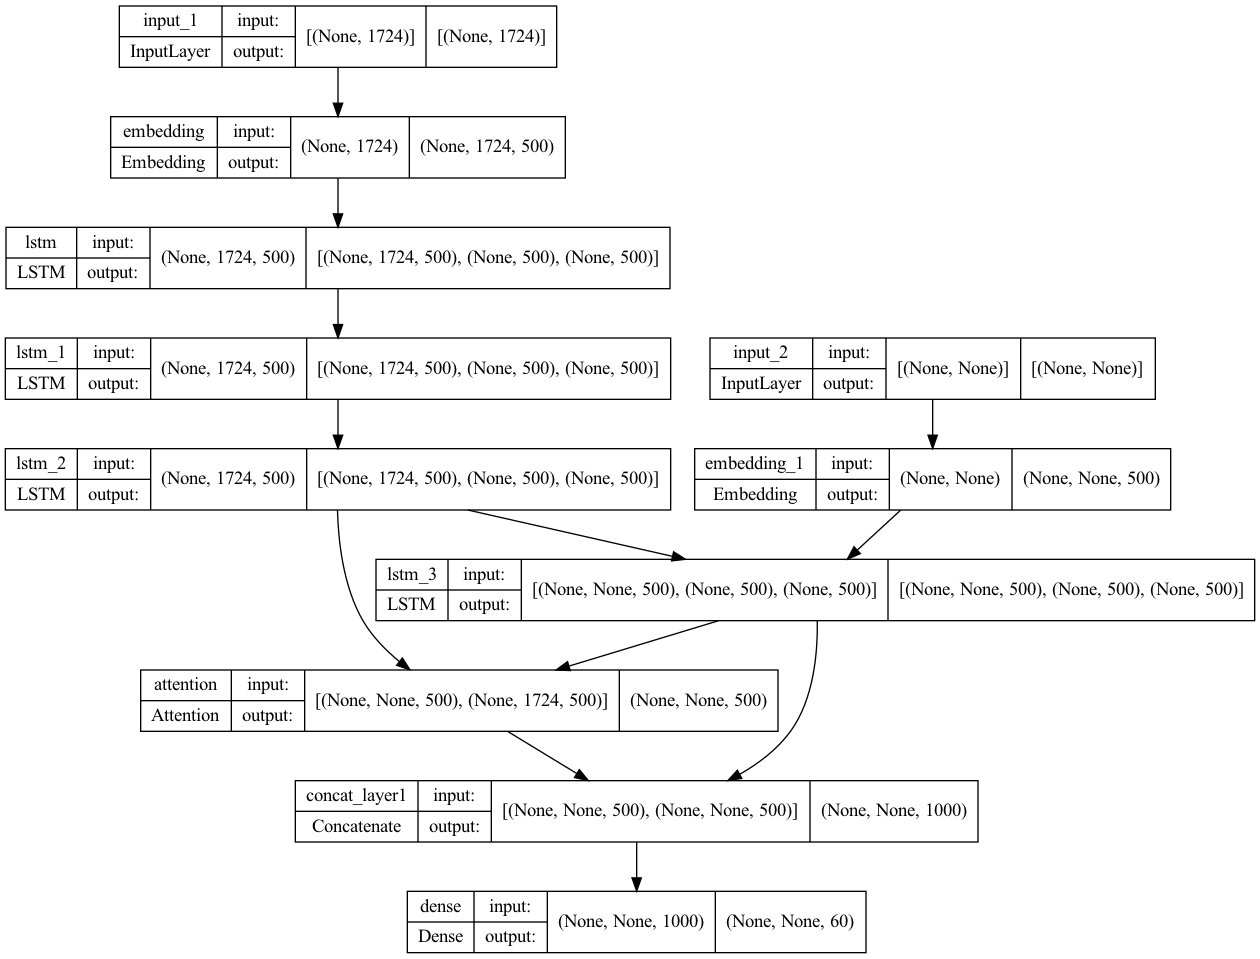

In [24]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.compile(optimizer = "rmsprop",loss="sparse_categorical_crossentropy", metrics=["accuracy"], )

In [26]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

In [27]:
history = model.fit([en_in_data, dec_in_data],dec_tr_data,batch_size=24,epochs=10,validation_split=0.2,verbose=1)

Epoch 1/10


2022-04-13 02:33:10.512539: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-13 02:33:13.005030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:33:13.160731: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-04-13 02:33:13.463209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:33:19.313654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:33:25.254769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regi

266/266 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.8666

2022-04-13 02:51:48.450930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:51:48.505078: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-04-13 02:51:48.591845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:51:54.461567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:52:00.376385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 02:52:06.279694: I tensorflow/core/grappler/opti

266/266 [==============================] - 1237s 4s/step - loss: 0.1150 - accuracy: 0.8666 - val_loss: 0.0806 - val_accuracy: 0.8714
Epoch 2/10
266/266 [==============================] - 1051s 4s/step - loss: 0.0827 - accuracy: 0.8701 - val_loss: 0.0808 - val_accuracy: 0.8714
Epoch 3/10
266/266 [==============================] - 1053s 4s/step - loss: 0.0948 - accuracy: 0.8703 - val_loss: 0.0977 - val_accuracy: 0.8712
Epoch 4/10
266/266 [==============================] - 1052s 4s/step - loss: 0.0841 - accuracy: 0.8707 - val_loss: 0.0751 - val_accuracy: 0.8722
Epoch 5/10
266/266 [==============================] - 1053s 4s/step - loss: 0.0753 - accuracy: 0.8708 - val_loss: 0.0751 - val_accuracy: 0.8722
Epoch 6/10
266/266 [==============================] - 1052s 4s/step - loss: 0.0795 - accuracy: 0.8705 - val_loss: 0.0777 - val_accuracy: 0.8720
Epoch 7/10
266/266 [==============================] - 1052s 4s/step - loss: 0.0799 - accuracy: 0.8708 - val_loss: 0.0792 - val_accuracy: 0.8722
Epo

In [28]:
# save model
model.save('text_summarizer.h5')
print('Model Saved!')

Model Saved!


In [29]:
import joblib

joblib.dump(in_tokenizer,'text_tokenizer.pkl')
joblib.dump(tr_tokenizer,'summary_tokenizer.pkl')

['summary_tokenizer.pkl']

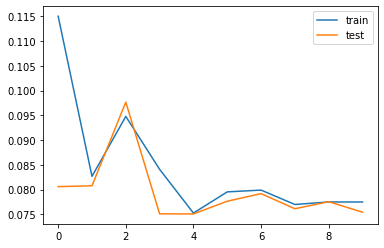

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [76]:
history.history

{'loss': [0.11502010375261307,
  0.08267617970705032,
  0.09478013217449188,
  0.08409368246793747,
  0.07525913417339325,
  0.07953823357820511,
  0.07989970594644547,
  0.07699514180421829,
  0.077499620616436,
  0.07749653607606888],
 'accuracy': [0.8666318655014038,
  0.8701267838478088,
  0.8703023791313171,
  0.8706714510917664,
  0.870755136013031,
  0.8704848885536194,
  0.8707537651062012,
  0.8707983493804932,
  0.8707983493804932,
  0.8707764148712158],
 'val_loss': [0.08059963583946228,
  0.08077021688222885,
  0.09766695648431778,
  0.0751028060913086,
  0.07508780062198639,
  0.07765575498342514,
  0.07918591797351837,
  0.0761309415102005,
  0.07755613327026367,
  0.075434111058712],
 'val_accuracy': [0.8714368939399719,
  0.8714341521263123,
  0.8711598515510559,
  0.872218668460846,
  0.872218668460846,
  0.8719663023948669,
  0.8721857070922852,
  0.8722131848335266,
  0.8722159266471863,
  0.8722159266471863]}

In [77]:
results = model.evaluate([en_in_data, dec_in_data],dec_tr_data)
print("test loss, test acc:", results)

249/249 [==============================] - 365s 1s/step - loss: 0.1188 - accuracy: 0.8709
test loss, test acc: [0.1187753900885582, 0.8709298968315125]


# Inference

In [79]:
import joblib

# seq2seq model
model = models.load_model("text_summarizer.h5")
# text tokenizer
in_tokenizer = joblib.load('text_tokenizer.pkl')
# summary tokenizer
tr_tokenizer = joblib.load('summary_tokenizer.pkl')

In [80]:
# encoder inference
latent_dim=500
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model([dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],[dec_outputs2] + [state_h2, state_c2])

In [81]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

In [82]:
def decode_sequence(input_seq):
    # get the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)

    # target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    # if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    # append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition:
        # get predicted output, hidden and cell state.
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])

        # get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word + " "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
            stop_condition = True

        # update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    # return the deocded sentence
    return decoded_sentence

In [109]:
new_inp = input("Enter : ")

new_inp = clean_text(new_inp)
new_inp = ' '.join(new_inp)
inp_x = in_tokenizer.texts_to_sequences([new_inp])
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

summary = decode_sequence(inp_x.reshape(1, max_in_len))
summary = target_texts[0]
summary = summary.replace('eos', '')
summary = summary.replace('sos', '')
print("\nPredicted summary:", summary);

Enter :  'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but becaus


Predicted summary:  syrian official obama climbed top tree doesnt know get obama sends letter heads house senate obama seek congressional approval military action syria aim determine whether cw used says u n spokesman 


In [ ]:
import coremltools as ct
ml = ct.convert(model)